# CO2 vs GDP

Data used:

CO2: https://github.com/owid/co2-data?tab=readme-ov-file  
GDP annual : https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?end=2024&start=1960

## Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
gdp = pd.read_csv("gdp.csv", skiprows=4) # Metadata rows skipped
co2 = pd.read_csv("owid-co2-data.csv")

# Display basic infor and first few rows
print("GDP dataset columns:")
print(gdp.columns.tolist())
print("\nCo2 dataset columns:")
print(co2.columns.tolist())

# Top rows
print("\nGDP head:")
print(gdp.head())

print("\nCO2 head:")
print(co2.head())

GDP dataset columns:
['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', 'Unnamed: 69']

Co2 dataset columns:
['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2', 'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct', 'co2_including_luc', 'co2_including_luc_growth_abs', 'co2_including_luc_growth_prct', 'co2_including_luc_per_capita', 'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy', 'co2_per_capita', 'co2_per_gdp', 

In [3]:
# --- Clean GDP Data ---
# Drop empty columns
gdp = gdp.drop(columns=['Unnamed: 69'], errors='ignore')

# Melt from wide to long format
gdp_long = gdp.melt(
    id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
    var_name='year',
    value_name='gdp_usd'
)

# Convert year to int and drop non-numeric
gdp_long = gdp_long[gdp_long['year'].str.isnumeric()]
gdp_long['year'] = gdp_long['year'].astype(int)

# Keep only necessary columns
gdp_long = gdp_long[['Country Name', 'Country Code', 'year', 'gdp_usd']]

# --- Prepare CO2 data ---
co2_sub = co2[['country', 'year', 'iso_code', 'co2', 'co2_per_capita', 'population']]

# --- Merge datasets ---
merged = pd.merge(
    co2_sub,
    gdp_long,
    left_on=['iso_code', 'year'],
    right_on=['Country Code', 'year'],
    how='inner'
)

print(f"Merged dataset shape: {merged.shape}")
print(merged.head)

Merged dataset shape: (13184, 9)
<bound method NDFrame.head of            country  year iso_code     co2  co2_per_capita  population  \
0      Afghanistan  1960      AFG   0.414           0.046   9035048.0   
1      Afghanistan  1961      AFG   0.491           0.053   9214082.0   
2      Afghanistan  1962      AFG   0.689           0.073   9404411.0   
3      Afghanistan  1963      AFG   0.707           0.074   9604491.0   
4      Afghanistan  1964      AFG   0.839           0.085   9814318.0   
...            ...   ...      ...     ...             ...         ...   
13179     Zimbabwe  2019      ZWE  10.263           0.672  15271377.0   
13180     Zimbabwe  2020      ZWE   8.495           0.547  15526888.0   
13181     Zimbabwe  2021      ZWE  10.204           0.646  15797220.0   
13182     Zimbabwe  2022      ZWE  10.425           0.649  16069061.0   
13183     Zimbabwe  2023      ZWE  11.164           0.683  16340829.0   

      Country Name Country Code       gdp_usd  
0      Afgha

In [4]:
# Basic checks
print(merged.info())
print(merged.describe())

# Check for missing values
print("Missing Values")
print(merged.isna().sum().sort_values(ascending=False).head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13184 entries, 0 to 13183
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         13184 non-null  object 
 1   year            13184 non-null  int64  
 2   iso_code        13184 non-null  object 
 3   co2             12692 non-null  float64
 4   co2_per_capita  12692 non-null  float64
 5   population      13184 non-null  float64
 6   Country Name    13184 non-null  object 
 7   Country Code    13184 non-null  object 
 8   gdp_usd         11116 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 927.1+ KB
None
               year           co2  co2_per_capita    population       gdp_usd
count  13184.000000  12692.000000    12692.000000  1.318400e+04  1.111600e+04
mean    1991.500000    115.073989        5.263354  2.645192e+07  1.910809e+11
std       18.473654    561.898047       12.429682  1.079755e+08  1.064883e+12
min     1960.000

In [5]:
# Drop rows missing GDP or CO2
cleaned = merged.dropna(subset=['gdp_usd', 'co2'])

print(f"Before: {merged.shape}, After cleaning: {cleaned.shape}")

Before: (13184, 9), After cleaning: (10883, 9)


## Exploratory Data Analysis

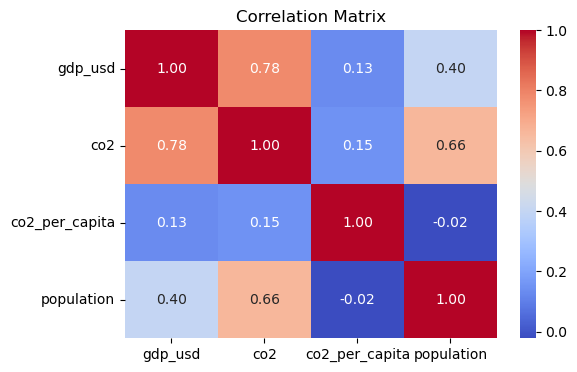

In [6]:
# Correlation and Overview
corr = cleaned[['gdp_usd', 'co2', 'co2_per_capita', 'population']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Interpretation

* GDP vs CO2 strong positive correlation. Effect of economic scale.
* Population vs CO2 also positive correlation, larger populations emit more CO2.
* C02 per capita, weak correlation.

### Global Trend

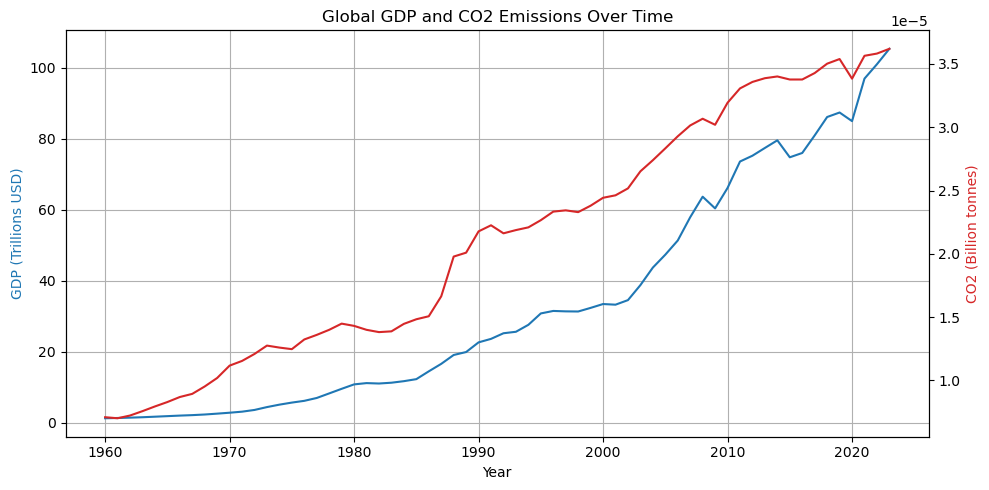

In [7]:
global_trend = cleaned.groupby('year')[['gdp_usd','co2']].sum().reset_index()

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(global_trend['year'], global_trend['gdp_usd']/1e12, color='tab:blue', label='Global GDP (Trillion USD)')
ax2 = ax1.twinx()
ax2.plot(global_trend['year'], global_trend['co2']/1e9, color='tab:red', label='Global CO2 (Billion tonnes)')

ax1.set_xlabel('Year')
ax1.set_ylabel('GDP (Trillions USD)', color='tab:blue')
ax2.set_ylabel('CO2 (Billion tonnes)', color='tab:red')
ax1.set_title('Global GDP and CO2 Emissions Over Time')
ax1.grid(True)
fig.tight_layout()
plt.show()

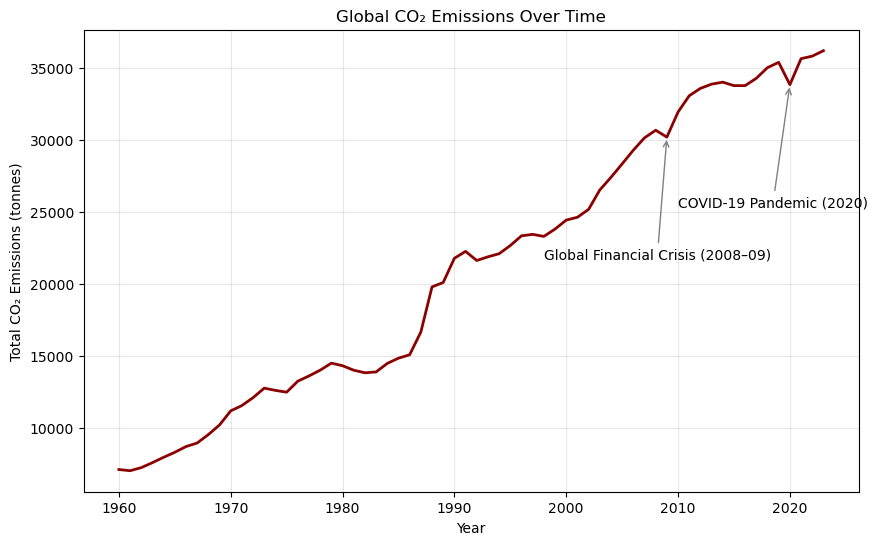

In [42]:
plt.figure(figsize=(10,6))
plt.plot(global_trend['year'], global_trend['co2'], color='darkred', linewidth=2)
plt.title("Global CO₂ Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("Total CO₂ Emissions (tonnes)")

# Annotate dips
plt.annotate("Global Financial Crisis (2008–09)",
             xy=(2009, global_trend.loc[global_trend['year']==2009, 'co2'].values[0]),
             xytext=(1998, global_trend['co2'].max()*0.6),
             arrowprops=dict(arrowstyle="->", color='gray'))

plt.annotate("COVID-19 Pandemic (2020)",
             xy=(2020, global_trend.loc[global_trend['year']==2020, 'co2'].values[0]),
             xytext=(2010, global_trend['co2'].max()*0.7),
             arrowprops=dict(arrowstyle="->", color='gray'))

plt.grid(True, alpha=0.3)
plt.show()


## Interpretation

2009 and 2020 economic crisis can be seen in the graph. Sharper decline in CO2, in comparison to decline before 2010 might be due to Covid lockdowns.

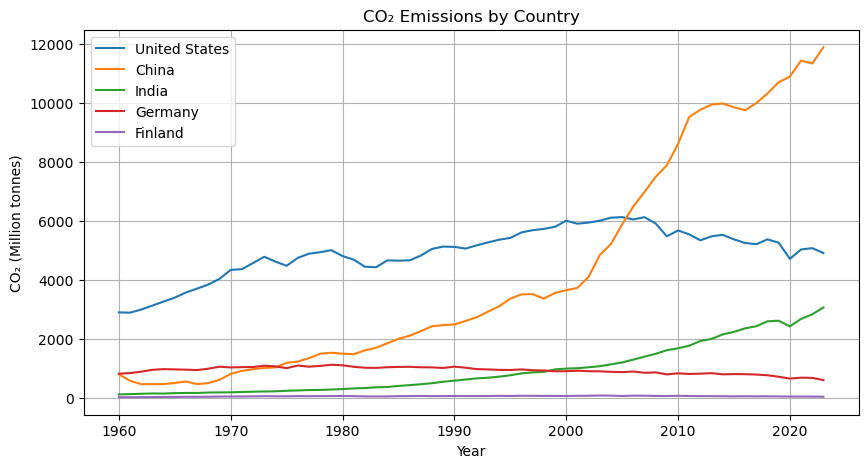

In [8]:
countries = ['United States', 'China', 'India', 'Germany', 'Finland']
plt.figure(figsize=(10,5))

for c in countries:
    subset = cleaned[cleaned['country'] == c]
    plt.plot(subset['year'], subset['co2'], label=c)

plt.title('CO₂ Emissions by Country')
plt.xlabel('Year')
plt.ylabel('CO₂ (Million tonnes)')
plt.legend()
plt.grid(True)
plt.show()


### CO2 Efficiency (CO2 per GDP)

/tmp/ipykernel_32457/649612866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['co2_per_gdp'] = cleaned['co2'] / cleaned['gdp_usd']


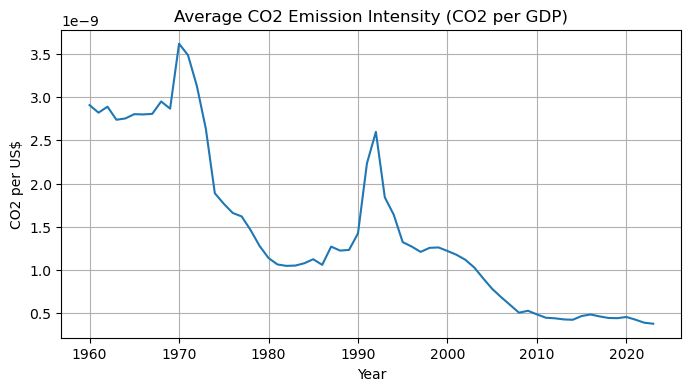

In [9]:
# CO2 per GDP column
cleaned['co2_per_gdp'] = cleaned['co2'] / cleaned['gdp_usd']

eff_trend = cleaned.groupby('year')['co2_per_gdp'].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(eff_trend['year'], eff_trend['co2_per_gdp'])
plt.title('Average CO2 Emission Intensity (CO2 per GDP)')
plt.xlabel('Year')
plt.ylabel('CO2 per US$')
plt.grid(True)
plt.show()

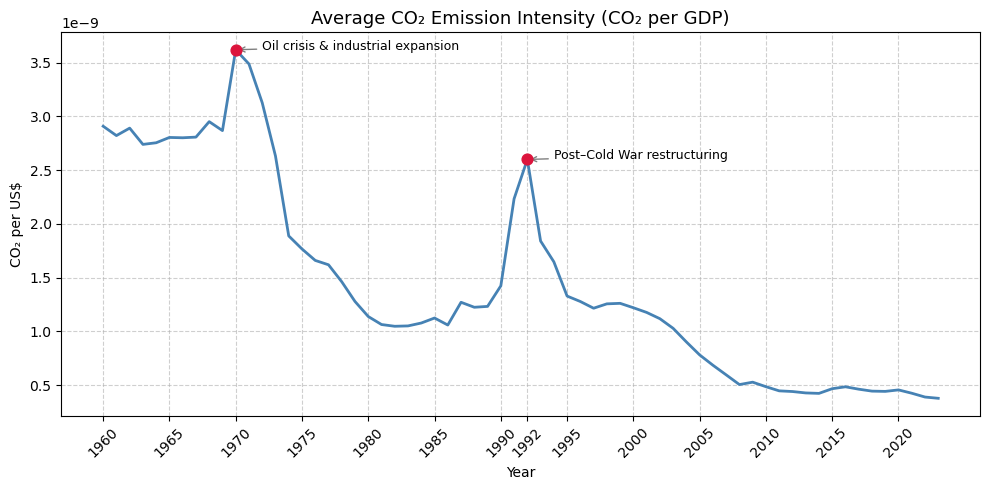

In [55]:
plt.figure(figsize=(10,5))

# Plot the CO₂ intensity line
plt.plot(eff_trend['year'], eff_trend['co2_per_gdp'], color='steelblue', linewidth=2)
plt.title('Average CO₂ Emission Intensity (CO₂ per GDP)', fontsize=13)
plt.xlabel('Year')
plt.ylabel('CO₂ per US$')
plt.grid(True, linestyle='--', alpha=0.6)

# Highlight key years with markers
key_years = [1970, 1992]
for year in key_years:
    if year in eff_trend['year'].values:
        y_val = eff_trend.loc[eff_trend['year'] == year, 'co2_per_gdp'].values[0]
        plt.scatter(year, y_val, color='crimson', s=60, zorder=5)

# Annotate historical context
annotations = {
    1970: "Oil crisis & industrial expansion",
    1992: "Post–Cold War restructuring"
}

for year, text in annotations.items():
    if year in eff_trend['year'].values:
        y_val = eff_trend.loc[eff_trend['year'] == year, 'co2_per_gdp'].values[0]
        plt.annotate(
            text,
            xy=(year, y_val),
            xytext=(year+2, y_val),
            fontsize=9,
            arrowprops=dict(arrowstyle="->", color='gray', lw=1),
            color='black'
        )

# Set x-ticks and rotate labels
highlight_years = sorted(set(list(range(int(eff_trend['year'].min()), int(eff_trend['year'].max())+1, 5)) + key_years))
plt.xticks(highlight_years, rotation=45)

plt.tight_layout()
plt.show()

### Interpretation

Peaks indicate drop in efficiency. More carbon generated per GDP generated. More GDP produced per CO2 over the years. Indicates improved sustainability over the years.

## GDP vs CO2 Scatter (Log-Log Scale)

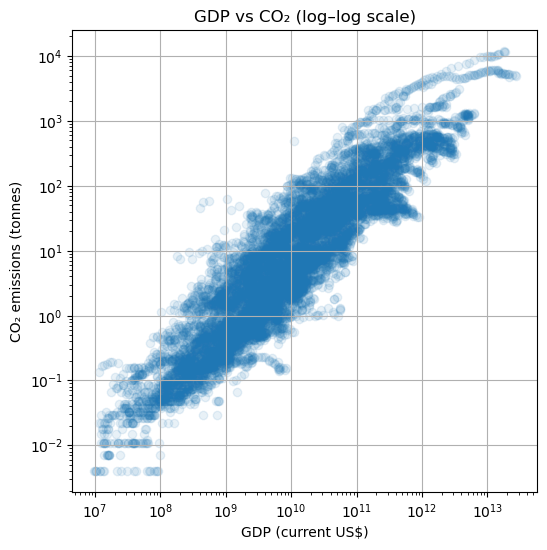

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(cleaned['gdp_usd'], cleaned['co2'], alpha=0.1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('GDP (current US$)')
plt.ylabel('CO₂ emissions (tonnes)')
plt.title('GDP vs CO₂ (log–log scale)')
plt.grid(True)
plt.show()

## Machine Learning 

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

### Setup and Feature Engineering

In [12]:
# Using cleaned dataset
data = cleaned.copy()

# Filter out zero or missing CO₂, GDP, or population before log-transforming
data = data[(data['co2'] > 0) & (data['gdp_usd'] > 0) & (data['population'] > 0)]

# Log-transform skewed variables (useful with linear models)
data['log_gdp'] = np.log(data['gdp_usd'])
data['log_pop'] = np.log(data['population'])
data['log_co2'] = np.log(data['co2'])



# Features and target
X = data[['log_gdp', 'log_pop']]  # Features
y = data['log_co2']               # Target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [13]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print("Coefficients:")
print(f"log_gdp: {lr.coef_[0]:.3f}, log_pop: {lr.coef_[1]:.3f}, intercept: {lr.intercept_:.3f}")

R²: 0.844
MAE: 0.834
Coefficients:
log_gdp: 0.823, log_pop: 0.197, intercept: -20.019


### Visualization

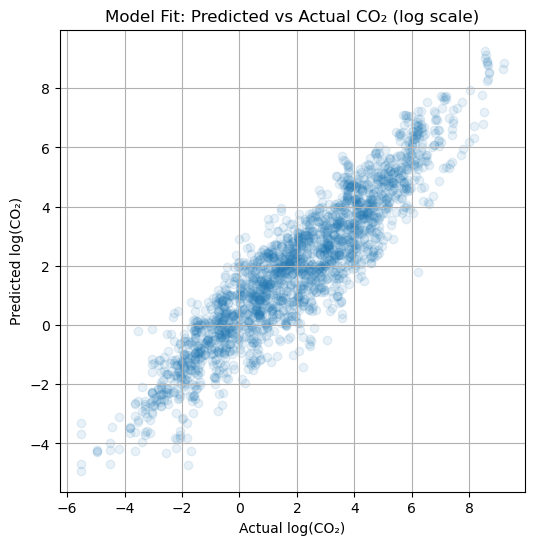

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual log(CO₂)")
plt.ylabel("Predicted log(CO₂)")
plt.title("Model Fit: Predicted vs Actual CO₂ (log scale)")
plt.grid(True)
plt.show()

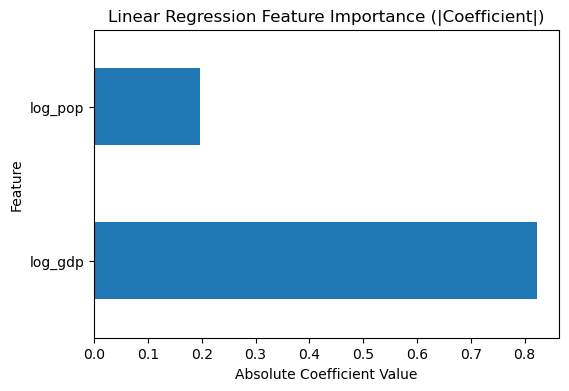

log_gdp    0.823010
log_pop    0.196562
dtype: float64

In [15]:
coeffs = pd.Series(lr.coef_, index=X_train.columns)

# Normalize by absolute magnitude for comparison
coeffs_abs = coeffs.abs().sort_values(ascending=False)

plt.figure(figsize=(6,4))
coeffs_abs.plot(kind='barh')
plt.title("Linear Regression Feature Importance (|Coefficient|)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.show()

coeffs

### Non-Linear Model (Random Forest Regressor)

In [16]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f"Random Forest R²: {r2_score(y_test, y_pred_rf):.3f}")

y_pred_exp = np.exp(y_pred)
y_test_exp = np.exp(y_test)

# Evaluate on log scale
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest R² (log scale): {r2_rf:.3f}")
print(f"Random Forest MAE (log scale): {mae_rf:.3f}")
print(f"MAE (in raw CO₂ units): {mean_absolute_error(y_test_exp, y_pred_exp):.2e}")

Random Forest R²: 0.873
Random Forest R² (log scale): 0.873
Random Forest MAE (log scale): 0.663
MAE (in raw CO₂ units): 6.82e+01


### Random Forest Regressor Visualization

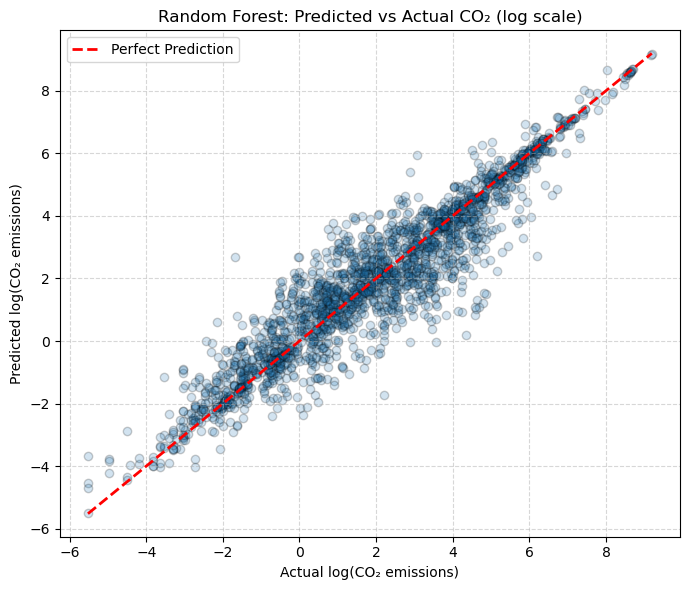

In [17]:
# Scatter plot for predicted vs actual (log scale)
plt.figure(figsize=(7, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.2, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')

plt.xlabel("Actual log(CO₂ emissions)")
plt.ylabel("Predicted log(CO₂ emissions)")
plt.title("Random Forest: Predicted vs Actual CO₂ (log scale)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Feature Importance Plots

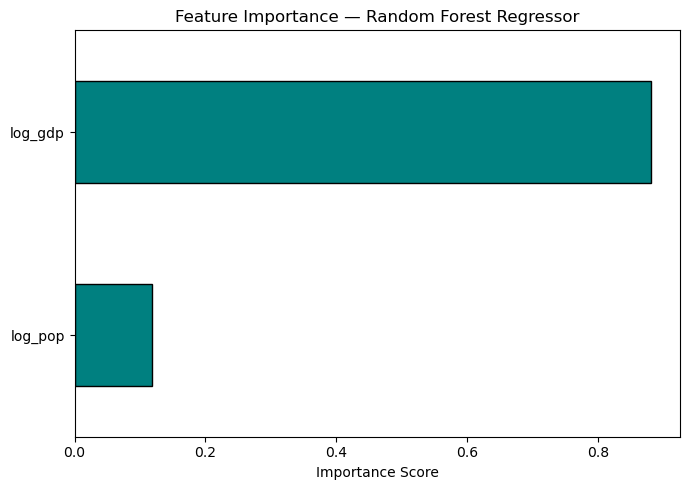

In [18]:
# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# Sort and plot
plt.figure(figsize=(7, 5))
importances.sort_values(ascending=True).plot(kind='barh', color='teal', edgecolor='k')

plt.title("Feature Importance — Random Forest Regressor")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### Residual Plots

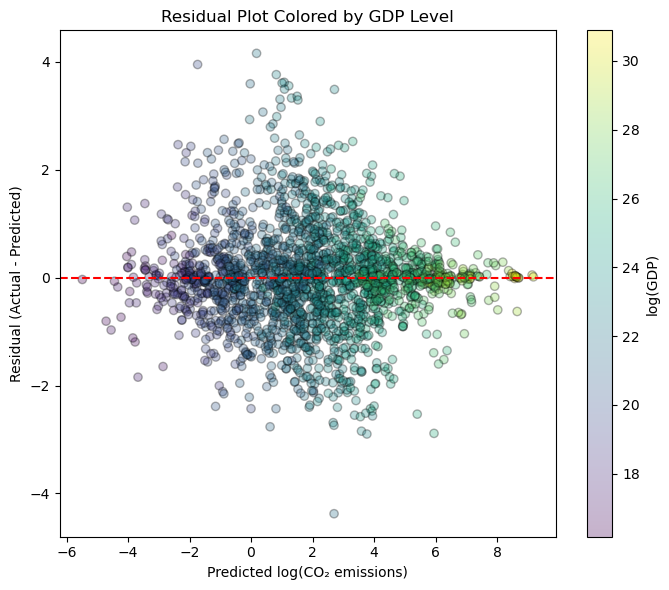

In [19]:
# Calculate residuals
residuals = y_test - y_pred_rf

plt.figure(figsize=(7, 6))
plt.scatter(y_pred_rf, residuals, c=X_test['log_gdp'], cmap='viridis', alpha=0.3, edgecolor='k')
plt.colorbar(label='log(GDP)')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted log(CO₂ emissions)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot Colored by GDP Level")
plt.tight_layout()
plt.show()

### GDP per Capita Feature

In [25]:
data_pc = cleaned.copy()

# Filter out zeros or missing values for CO₂, GDP, or population
data_pc = data_pc[(data_pc['co2'] > 0) & (data_pc['gdp_usd'] > 0) & (data_pc['population'] > 0)]

# Create GDP per capita
data_pc['gdp_per_capita'] = data_pc['gdp_usd'] / data_pc['population']

# Log-transform variables
data_pc['log_gdp_pc'] = np.log(data_pc['gdp_per_capita'])
data_pc['log_pop'] = np.log(data_pc['population'])
data_pc['log_co2'] = np.log(data_pc['co2'])

In [26]:
# Use log_gdp_pc and log_pop as features
X_pc = data_pc[['log_gdp_pc', 'log_pop']]
y_pc = data_pc['log_co2']

X_train_pc, X_test_pc, y_train_pc, y_test_pc = train_test_split(
    X_pc, y_pc, test_size=0.2, random_state=42
)

In [27]:
rf_pc = RandomForestRegressor(n_estimators=200, random_state=42)
rf_pc.fit(X_train_pc, y_train_pc)

y_pred_pc = rf_pc.predict(X_test_pc)

r2_pc = r2_score(y_test_pc, y_pred_pc)
mae_pc = mean_absolute_error(y_test_pc, y_pred_pc)

print(f"Random Forest R² (log scale, with GDP per capita): {r2_pc:.3f}")
print(f"Random Forest MAE (log scale, with GDP per capita): {mae_pc:.3f}")

Random Forest R² (log scale, with GDP per capita): 0.878
Random Forest MAE (log scale, with GDP per capita): 0.631


### Importance Check

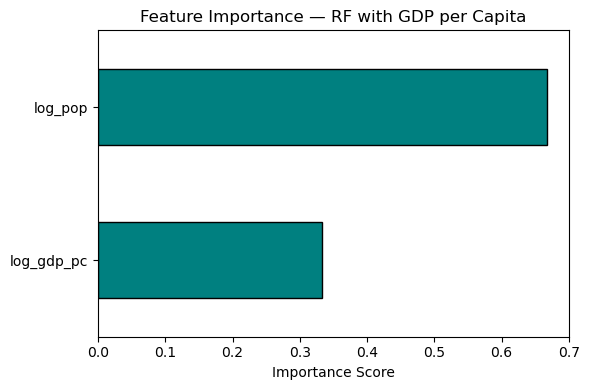

In [28]:
importances_pc = pd.Series(rf_pc.feature_importances_, index=X_train_pc.columns)

plt.figure(figsize=(6,4))
importances_pc.sort_values().plot(kind='barh', color='teal', edgecolor='k')
plt.title("Feature Importance — RF with GDP per Capita")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### Residuals

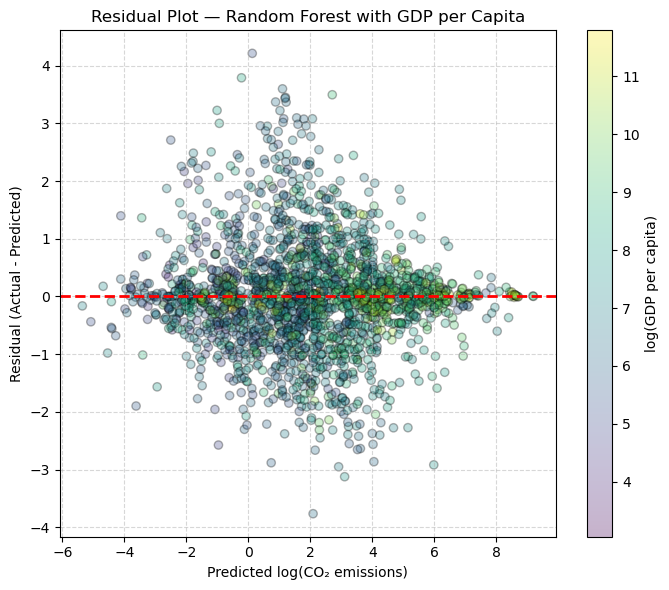

In [56]:
# Calculate residuals
residuals_pc = y_test_pc - y_pred_pc

# Residual plot
plt.figure(figsize=(7,6))
plt.scatter(y_pred_pc, residuals_pc, c=X_test_pc['log_gdp_pc'], cmap='viridis', alpha=0.3, edgecolor='k')
plt.colorbar(label='log(GDP per capita)')
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel("Predicted log(CO₂ emissions)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot — Random Forest with GDP per Capita")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Findings

### Models Summary

| Model                              | Predictors Used                      | Scale |   R²  |  MAE  | Key Feature Importance                     | Notes                                                       |
| :--------------------------------- | :----------------------------------- | :---- | :---: | :---: | :----------------------------------------- | :---------------------------------------------------------- |
| **Linear Regression**              | log(GDP), log(Population)            | log   | 0.844 | 0.834 | GDP (≈ 0.8), Population (≈ 0.2)            | Captures general trend; assumes linearity in log–log space  |
| **Random Forest**                  | log(GDP), log(Population)            | log   | 0.873 | 0.663 | GDP (≈ 0.8), Population (> 0.2)            | Nonlinear model; better fit with similar dominant variables |
| **Random Forest (GDP per capita)** | log(GDP per capita), log(Population) | log   | ~0.876 | ~0.631 | Population (≈ 0.7), GDP per capita (≈ 0.3) | Captures emission efficiency; shows population dominance    |

### Residual Plots

| Model                     | Residual Pattern                              | Interpretation                                               | Takeaway                                                                          |
| :------------------------ | :-------------------------------------------- | :----------------------------------------------------------- | :-------------------------------------------------------------------------------- |
| **CO₂ vs total GDP**      | Bulge in center; GDP gradient visible         | Heteroscedasticity — error varies by GDP scale               | Transitional economies cause variability; may need nonlinear or regional modeling |
| **CO₂ vs GDP per capita** | Similar spread; random GDP color distribution | Reduced heteroscedasticity — bias removed, variance unchanged | Model fairer across economic scales; uncertainty evenly distributed               |

### Residual Analysis

After fitting bot **log-log models** for total CO2 and CO2 per capita, residual distributions were analyzed for potential biases and asses model fit.

**CO2 vs Total GDP**  
* **Observation:** Residuals form a bulge in the center, wider spread for mid-GDP countries and narrower at bot low and high GDP extremes.
* **Color pattern:** Residuals are visibly ordered by GDP level - lower-GDP nations cluster on the left and seem to have higher variance. High-GDP nations are clustered on the right ans seem to have lower varance.
* **Interpretation:** This pattern indicate **heteroscedasticity** - model errors vary by GDP scale.
    *  Mid-income nations tend to deviate fromglobal CO2-GDP trend. Probably due to diverse economic structures and transitions (e.g., mixed energy sources, industrialization)
    *  Rich economies show more stable, predictable emission levels relative to GDP while low-income countries contribute little to global totals, reducing their influence.

Economically, this might suggest CO2-GDP relationshio is not uniform and transitional economies are source of the model's uncertainty.

  
**CO2 vs GDP per Capita**  
* **Observation:** Residuals still spread in similar manner to previous model. But there is **no clear GDP-based color gradient.**
* **Interpretation:**
    * Uncertainty is still an issue but model is **fair**.
    * Absence of color clustering means residuals **no longer systemically linked to GDP size**.
    * Normalizing by population removes **GDP-dependent bias**, but error magnitude remains similar. This suggests **reduced heteroscedasticity**, though not perfect homoscedasticity.

The overall spread of residuals remains similar between total GDP and GDP per capita models, indicating comparable uncertainty levels. However, the disappearance of the GDP-level color gradient suggests that the per-capita model no longer exhibits GDP-related bias — improving fairness across different economic scales, even if not reducing overall model variance.